# Label Propagation

In [1]:
#from shapely.geometry import Point, Polygon
import geopandas as gpd
import requests
from tqdm.auto import tqdm
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import rasterio as rs
from rasterio.mask import mask
from rasterio.merge import merge
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from glob import glob
import os

# Prepare Inputs

## Input Raster Datasets

In [2]:
# download tiles for costa rica
# aws s3 cp s3://esa-worldcover-s2/rgbnir/2020/N08/ESA_WorldCover_10m_2020_v100_N08W083_S2RGBNIR.tif /Users/jessica.ertel/plantation_classifier/data/label_prop/costa_rica/s2/

In [27]:
# Mosaic sentinel files then clip to Costa Rica boundary

def merge_and_clip(country, data):
    
    folder = (f'../data/label_prop/{country}/')

    # now open each item in dataset reader mode (required to merge)
    reader_mode = []

    for file in glob(f'{folder}{data}/*.tif'):
        src = rs.open(file)
        reader_mode.append(src) 

    # for s2 and s1 nodata value is 0
    mosaic, out_transform = merge(reader_mode)
    
    # outpath will be the new filename
    merged = f'{folder}{country + data}_merged.tif'
    out_meta = src.meta.copy()  
    out_meta.update({'driver': "GTiff",
                     'dtype': 'uint16',  
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_transform,
                     'compress':'lzw'})

    with rs.open(merged, "w", **out_meta, BIGTIFF='YES') as dest:
        dest.write(mosaic)

    # now clip merged tif to country boundaries
    merged = f'{folder}{country + data}_merged.tif'
    shapefile = gpd.read_file(f'{folder}gadm41_CRI_0.shp')
    clipped = f'{folder}{country + data}_clipped.tif'

    with rs.open(merged) as src:
        shapefile = shapefile.to_crs(src.crs)
        out_image, out_transform = mask(src, shapefile.geometry, crop=True)
        out_meta = src.meta.copy() 

    out_meta.update({
        "driver":"Gtiff",
        "height":out_image.shape[1], # height starts with shape[1]
        "width":out_image.shape[2], # width starts with shape[2]
        "transform":out_transform
    })

    with rs.open(clipped,'w',**out_meta, BIGTIFF='YES') as dst:
        dst.write(out_image)
    
    print(f'{len(reader_mode)} tifs merged and clipped to {country}.')
    os.remove(merged)
    return None

In [28]:
merge_and_clip('costa_rica', 's1')

13 tifs merged and clipped to costa_rica.


In [29]:
merge_and_clip('costa_rica', 's2')

13 tifs merged and clipped to costa_rica.


In [6]:
## reproject the lulc dataset to espg 4326 to match other input data
## taken verbatim from rasterio documentation w/ added compression params

from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rs.open('../data/testing/lulc_cr.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'compress': 'lzw',
        'dtype': 'uint8'})

    with rs.open('../data/testing/lulc_cr_reprj.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rs.band(src, i),
                destination=rs.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

## Extract Features

In [2]:
folder = ('../data/label_prop/')
ttc = rs.open(f'{folder}/costa_rica/CostaRica.tif')
sdpt = gpd.read_file(f'{folder}cri_sdpt_v2.shp')
lulc = rs.open(f'{folder}lulc_cr_reprj.tif')
cr = gpd.read_file(f'{folder}/costa_rica/gadm41_CRI_0_clipped.shp')
hc_poly = gpd.read_file(f'{folder}HighConf_poly1.shp')
s1 = rs.open(f'{folder}/costa_rica/costa_ricas1_clipped.tif')
s2 = rs.open(f'{folder}/costa_rica/costa_ricas2_clipped.tif')

In [3]:
labeled_pts = gpd.read_file(f'{folder}/HighConf_Point.shp')
labeled_pts = labeled_pts[['geometry', 'label']]
unlabeled_pts = gpd.read_file(f'{folder}/output_unlabelledPts.shp')

In [4]:
def get_pts(num_pts):
    
    # gets num_pts of unlabeled data
    print(f'Extracting {num_pts} unlabeled points...')
    print('(points are currently imported)')
    
    # add line to avoid points on cocos island
    # add line to drop any points that are NaN or 255 from TTC or LULC
    
    return points

In [5]:
def extract_raster_values(pts, raster):

    # Read points from shapefile
    pts = pts[['geometry']]
    pts.index = range(len(pts))
    coords = [(x,y) for x, y in zip(pts.geometry.x, pts.geometry.y)]

    # Sample the raster at every point location and store values
    pts['raster_val'] = [x[0] for x in raster.sample(coords)]
            
    return values


In [25]:
def get_features(pts, labels):
    
    '''
    Calculates num_pts within a designated area and extracts associated 
    attributes from 3 rasters. Returns dataframe where each row
    represents an unlabeled observation.
    
    Data dictionary
    SDPT: forest plantations = 2.0, oil palm = 1.0, orchard = 7215
    LULC: 
    
    '''

    # import ttc, sdpt and lulc data and confirm crs
    ttc = rs.open('../data/label_prop/costa_rica/CostaRica.tif')
    sdpt = gpd.read_file('../data/label_prop/cri_sdpt_v2.shp')
    lulc = rs.open('../data/label_prop/lulc_cr_reprj.tif')
    s1 = rs.open(f'{folder}/costa_rica/costa_ricas1_clipped.tif')
    s2 = rs.open(f'{folder}/costa_rica/costa_ricas2_clipped.tif')
    
    assert ttc.crs == sdpt.crs == lulc.crs == s1.crs == s2.crs == pts.crs
    
    coords = [(x,y) for x, y in zip(pts.geometry.x, pts.geometry.y)]
    
    # create new df to hold extracted attributes
    pts['point_x'] = pts.geometry.x
    pts['point_y'] = pts.geometry.y
    pts['ttc'] = [x[0] for x in ttc.sample(coords)]
    pts['lulc'] = [x[0] for x in lulc.sample(coords)]
    pts['s1'] = [x[0] for x in s1.sample(coords)]
    pts['s2'] = [x[0] for x in s2.sample(coords)]

    # for sdpt must perform a join before extraction
    intersection = gpd.sjoin(pts, sdpt[['originalCo', 'originalNa', 'geometry']], how='left', predicate='within')
    pts['sdpt'] = intersection['originalCo']
    
    # if there is no sentinel 1 or 2 data, drop the sample
    # no s1 bc of terrain shadow and no s2 bc of clouds
    pts = pts[pts.s1 != 0.0]
    pts = pts[pts.s2 != 0.0]
    
    if labels:
        pts['label'] = pts['label'].map({'notplantation': '0', 'monoculture': '1', 'agroforestry': '2'})
    else:
        pts['label'] = '-1'
    
    
    pts[['lulc', 'sdpt', 'ttc']] = pts[['lulc', 'sdpt', 'ttc']].astype(str)
    print(f'{len(pts)} total samples')
    
    return pts

In [26]:
labeled = get_features(labeled_pts, labels=True)

2089 total samples


In [10]:
unlabeled = get_features(unlabeled_pts, labels=False)

1994 total samples


In [11]:
unlabeled.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1994 entries, 0 to 1998
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       1994 non-null   int64   
 1   geometry  1994 non-null   geometry
 2   point_x   1994 non-null   float64 
 3   point_y   1994 non-null   float64 
 4   ttc       1994 non-null   object  
 5   lulc      1994 non-null   object  
 6   s1        1994 non-null   uint16  
 7   s2        1994 non-null   uint16  
 8   sdpt      1994 non-null   object  
 9   label     1994 non-null   object  
dtypes: float64(2), geometry(1), int64(1), object(4), uint16(2)
memory usage: 148.0+ KB


## EDA

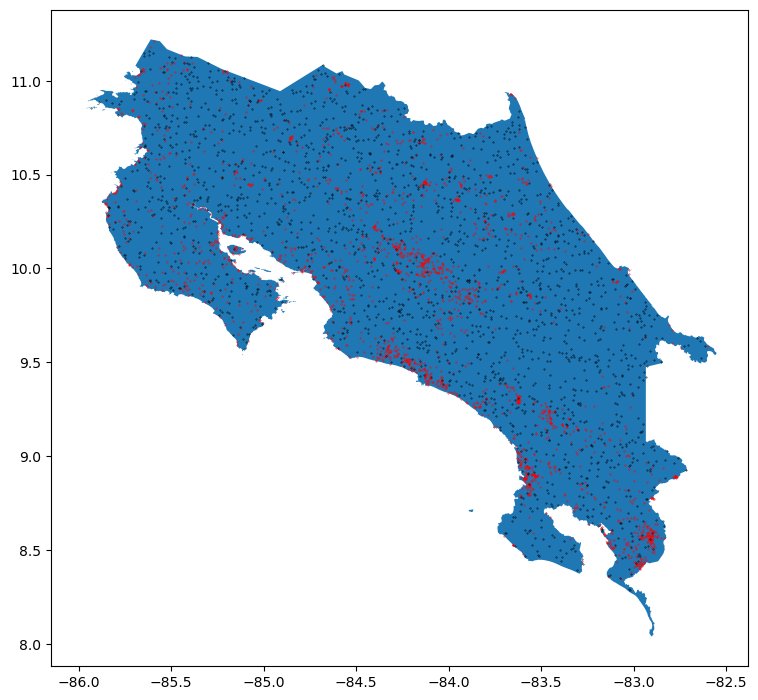

In [12]:
# quick visual to get a sense of the location of labeled and unlabeled points
ax = cr.plot(figsize=(9,9))
labeled.plot(ax=ax, color='red', markersize=0.1)
unlabeled.plot(ax=ax, color='black', markersize=0.1);

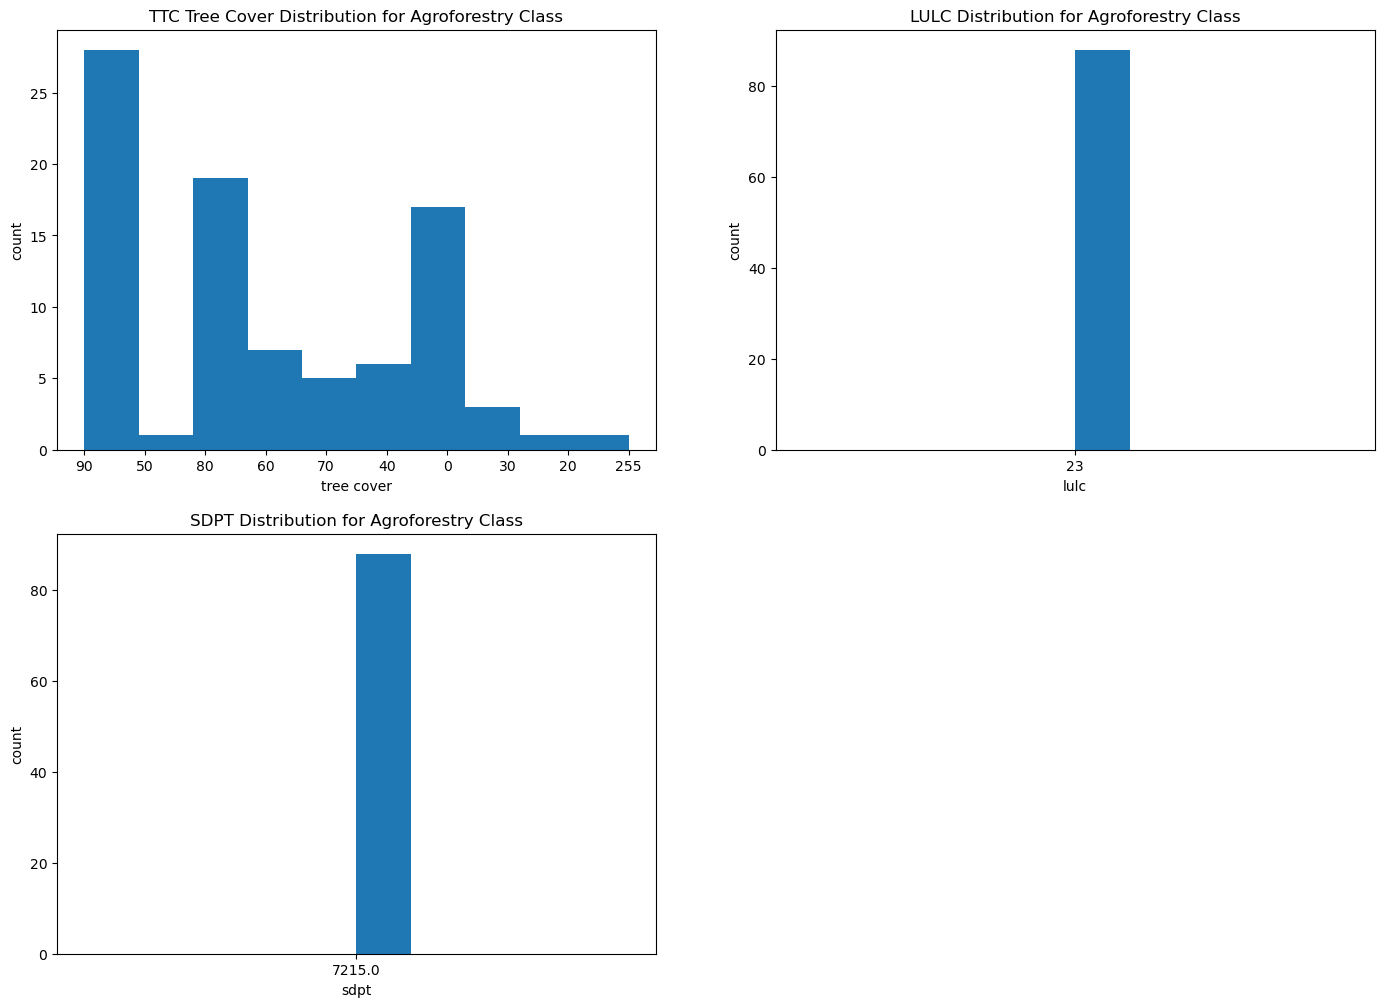

In [41]:
plt.figure(figsize=(17,12)) 

plt.subplot(2,2,1)
plt.hist(labeled[labeled.label == '2'].ttc)
plt.xlabel('tree cover')
plt.ylabel('count')
plt.title('TTC Tree Cover Distribution for Agroforestry Class')

plt.subplot(2,2,2)
plt.hist(labeled[labeled.label == '2'].lulc)
plt.xlabel('lulc')
plt.ylabel('count')
plt.title('LULC Distribution for Agroforestry Class')

plt.subplot(2,2,3)
plt.hist(labeled[labeled.label == '2'].sdpt)
plt.xlabel('sdpt')
plt.ylabel('count')
plt.title('SDPT Distribution for Agroforestry Class');

## Prepare Model Input
Confirm that the labeled and unlabeled dataframes match so they can be combined as input to the models.

In [14]:
display(labeled.info())
display(unlabeled.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2089 entries, 0 to 2193
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  2089 non-null   geometry
 1   label     2089 non-null   object  
 2   point_x   2089 non-null   float64 
 3   point_y   2089 non-null   float64 
 4   ttc       2089 non-null   object  
 5   lulc      2089 non-null   object  
 6   s1        2089 non-null   uint16  
 7   s2        2089 non-null   uint16  
 8   sdpt      2089 non-null   object  
dtypes: float64(2), geometry(1), object(4), uint16(2)
memory usage: 138.7+ KB


None

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1994 entries, 0 to 1998
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FID       1994 non-null   int64   
 1   geometry  1994 non-null   geometry
 2   point_x   1994 non-null   float64 
 3   point_y   1994 non-null   float64 
 4   ttc       1994 non-null   object  
 5   lulc      1994 non-null   object  
 6   s1        1994 non-null   uint16  
 7   s2        1994 non-null   uint16  
 8   sdpt      1994 non-null   object  
 9   label     1994 non-null   object  
dtypes: float64(2), geometry(1), int64(1), object(4), uint16(2)
memory usage: 148.0+ KB


None

## Supervised Learning: Logistic Regression
Perform an initial supervised learning exercise using only the labeled data (to create a baseline for comparison). Since we have 3 classes, we are using multinomial logistic regression.  

Solvers   
liblinear: This is a simple solver that works well for small datasets. It uses a coordinate descent algorithm to optimize the coefficients of the model. It is efficient and can handle L1 and L2 regularization. However, it does not support multinomial logistic regression.  

lbfgs: This is a quasi-Newton method that approximates the Hessian matrix of the cost function. It is a good all-purpose solver that works well for small to medium-sized datasets. It can handle both L1 and L2 regularization and supports multinomial logistic regression.  

newton-cg: This solver uses a Newton-CG algorithm to optimize the coefficients of the model. It is efficient and works well for small to medium-sized datasets. It can handle both L1 and L2 regularization and supports multinomial logistic regression.  

sag: This is a stochastic gradient descent solver that works well for large datasets. It uses a variant of stochastic gradient descent that takes into account the previous gradient. It can handle both L1 and L2 regularization and supports multinomial logistic regression. Saga is an improved version of the sag solver that supports L1 regularization as well as elastic-net regularization. **Both require the training data to be scaled.**

In [15]:
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

In [17]:
X = labeled[['lulc','sdpt','ttc','s1','s2', 'point_x', 'point_y']]
X = pd.get_dummies(X, columns = ['lulc', 'sdpt', 'ttc'])
y = labeled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

# calc weighting to balance classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights)) 
print(f'class distribution:') 
print(f'{round(y.value_counts(normalize=True),2)}')
print(f'class weights: {class_weights}')

class distribution:
0    0.81
1    0.15
2    0.04
Name: label, dtype: float64
class weights: {'0': 0.41362916006339145, '1': 2.19327731092437, '2': 7.909090909090909}


In [18]:
model = LogisticRegression(multi_class='multinomial', 
                          solver='lbfgs', 
                          max_iter=400, 
                          class_weight=class_weights,
                          random_state=22)

model.fit(X_train, y_train)
cv = cross_val_score(model, X_train, y_train, cv=3).mean()
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
probs = model.predict_proba(X_test)
pred = model.predict(X_test)
f1 = f1_score(y_test, pred, average='weighted')
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')  
cv, train_score, test_score, f1, precision, recall

(0.9936143039591316,
 0.9974457215836526,
 0.9980879541108987,
 0.9980928327615257,
 0.9981118546845125,
 0.9980879541108987)

In [42]:
# Attempt with sampled data (because classes are highly imbalanced)?

# X = labeled_sample[['lulc','sdpt','ttc','s1','s2', 'point_x', 'point_y']]
# X = pd.get_dummies(X, columns = ['lulc', 'sdpt', 'ttc'])
# y = labeled_sample['label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

# model = LogisticRegression(multi_class='multinomial', 
#                           solver='lbfgs', 
#                           max_iter=500, 
#                           random_state=22)

# model.fit(X_train, y_train)
# cv = cross_val_score(model, X_train, y_train, cv=3).mean()
# train_score = model.score(X_train, y_train)
# test_score = model.score(X_test, y_test)
# probs = model.predict_proba(X_test)
# pred = model.predict(X_test)
# f1 = f1_score(y_test, pred, average='weighted')
# precision = precision_score(y_test, pred, average='weighted')
# recall = recall_score(y_test, pred, average='weighted')  
# cv, train_score, test_score, f1, precision, recall

## Semi-supervised Learning: Label Propagation
Perform a semi-supervised learning exercise where the algorithm will have the labeled and unlabeled data. Expect the semi-supervised learning algorithm to outperform the logistic regression model fit on the labeled data alone.  
Issue: Labels are categorical. Missing labels must be indicated by -1, however not clear that this approach works for categorical predictions because the algorithm should not be predicting that label.

In [19]:
X = labeled[['lulc','sdpt','ttc','s1','s2', 'point_x', 'point_y']]
y = labeled['label']

Xun = unlabeled[['lulc','sdpt','ttc','s1','s2', 'point_x', 'point_y']]
yun = unlabeled['label']

# create the mixed training dataset
X_mixed = pd.concat([X, Xun])
y_mixed = pd.concat([y, yun])

X_mixed = pd.get_dummies(X_mixed, columns = ['lulc', 'sdpt', 'ttc'])

# have to train test split after to ensure train and text have same representation
X_train, X_test, y_train, y_test = train_test_split(X_mixed, y_mixed, random_state=22, stratify=y_mixed)


print('Mixed Train Set:', X_train.shape, y_train.shape)
print('Test Set:', X_test.shape, y_test.shape)

Mixed Train Set: (3062, 38) (3062,)
Test Set: (1021, 38) (1021,)


In [22]:
semisuper_model = LabelPropagation()
semisuper_model.fit(X_train, y_train)
yhat = semisuper_model.predict(X_test)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

Accuracy: 0.4975514201762977


/Users/jessica.ertel/opt/anaconda3/envs/plantations4/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [23]:
X_test['preds'] = yhat
X_test.head()

,s1,s2,point_x,point_y,lulc_1,lulc_10,lulc_11,lulc_12,lulc_14,lulc_15,...,ttc_20,ttc_255,ttc_30,ttc_40,ttc_50,ttc_60,ttc_70,ttc_80,ttc_90,preds
246,39468,322,-84.219924,9.517038,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1984,38207,650,-84.313494,9.733769,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1920,37913,316,-85.351837,10.645842,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-1
132,39468,312,-83.748847,9.439729,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-1
1150,39524,374,-84.349718,9.604628,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-1


In [24]:
semisuper_model.classes_

array(['-1', '0', '1', '2'], dtype=object)

## Validation of outputs

## What Next
Option 1: Could we use the high confidence labeled centroids to generate a 14 x 14 grid of unlabeled points and use label propagation to label the rest of the points in the grid?

Concerns:
- some points are very close and may have overlapping grids which would need to have the same labels
- some degree of photointerpretation still feels necessary
- should pineapple be considered a monoculture plantation? SDPT labels pineapple as orchard

Roadblock
- in qgis cannot reproject to a crs with meters as units (points move to incorrect locations)


In [104]:
# this is output of Label Propagation vs what we need
ceo = pd.read_csv('../data/ceo-plantations-train-v20.csv')
display(X_test.head())
display(ceo.head())

,lulc,sdpt,ttc,point_x,point_y,preds
521,22.0,3.0,5,-83.456717,9.247454,0
1855,8.0,0.0,90,-83.233811,9.874400,-1
357,6.0,0.0,90,-85.728006,10.187768,-1
523,22.0,3.0,5,-83.477466,9.244667,0
972,6.0,0.0,80,-84.899885,9.821463,-1


,index,PLOT_ID,SAMPLE_ID,LON,LAT,EMAIL,FLAGGED,COLLECTION_TIME,ANALYSIS_DURATION,IMAGERY_TITLE,IMAGERY_ATTRIBUTIONS,SAMPLE_GEOM,SYSTEM,PLOT_FNAME,PLANTATION
0,0,0,-195,-0.894849,6.116158,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116157612001956),Unknown,20001,255
1,1,0,-194,-0.894849,6.116247,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116246932196532),Unknown,20001,255
2,2,0,-193,-0.894849,6.116336,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116336252376186),Unknown,20001,255
3,3,0,-192,-0.894849,6.116426,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116425572540933),Unknown,20001,255
4,4,0,-191,-0.894849,6.116515,jessica.ertel@wri.org,False,2023-06-28 19:26,98.8 secs,Mapbox Satellite,NaN,POINT(-0.894848875934758 6.116514892690745),Unknown,20001,255


In [42]:
# what if we use the labeled points to generate a 14x14 grid of 
# unlabeled points and use label propagation to label each grid
labeled.head()

,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,palm,monoculture,1.0,40,-83.598904,10.540394,POINT (-83.59890 10.54039)
1,palm,monoculture,1.0,40,-83.780329,10.496399,POINT (-83.78033 10.49640)
2,palm,monoculture,1.0,40,-83.798637,10.495866,POINT (-83.79864 10.49587)
3,palm,monoculture,1.0,40,-83.770438,10.491470,POINT (-83.77044 10.49147)
4,palm,monoculture,1.0,40,-83.776915,10.492586,POINT (-83.77692 10.49259)


Steps:
1. Reproject your points to a projected CRS with metres as units
2. Draw buffers with a radius of 50m (half of the grid size) around them with `Vector -> Geoprocessing Tools -> buffer(s)`
3. Create the vector grid with the extent of the buffer layer and 10m spacing


## Transform centroid to grid

In [ ]:
## Create a buffer around a centroid
# https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/

In [ ]:
def calculate_epsg(points: Tuple[float, float]) -> int:
    """ Calculates the UTM EPSG of an input WGS 84 lon, lat

        Parameters:
         points (tuple): input longitiude, latitude tuple

        Returns:
         epsg_code (int): integer form of associated UTM EPSG
    """
    lon, lat = points[0], points[1]
    utm_band = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0' + utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return int(epsg_code)

In [ ]:
def bounding_box(point: Tuple[float, float],
                 x_offset_max: int = 140,
                 y_offset_max: int = 140,
                 expansion: int = 10) -> Tuple[float, float]:

    tl = point

    epsg = calculate_epsg(tl)
    tl = convertCoords(tl, 4326, epsg)

    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max)))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]

    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]

    after = [b - a for a, b in zip(br, tl)]
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)

    min_x = tl[0]  # original X offset - 10 meters
    max_x = br[0]  # original X offset + 10*GRID_SIZE meters

    min_y = tl[1]  # original Y offset - 10 meters
    max_y = br[1]  # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

# References

© ESA WorldCover project 2020 / Contains modified Copernicus Sentinel data (2020) processed by ESA WorldCover consortium

In [ ]:
## Old

In [71]:
# X = labeled[['lulc','sdpt','ttc','s1','s2']]
# y = labeled['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

# # apply one hot encoding to all categorical variables
# # is this being applied to x_train/x_test
# cat_cols = ['sdpt', 'lulc']
# one_hot = OneHotEncoder(handle_unknown="ignore")
# preprocessor = ColumnTransformer([("one-hot-encoder", one_hot, cat_cols)])

# superv_model = make_pipeline(preprocessor, LogisticRegression(multi_class='multinomial', 
#                                                               solver='sag', 
#                                                               max_iter=500, 
#                                                               class_weight=class_weights,
#                                                               random_state=22))
# superv_model.fit(X_train, y_train)
# yhat = superv_model.predict(X_test)
# score = accuracy_score(y_test, yhat)
# print(f'Accuracy: {score}')


# extract_raster_values()
#     values = []
#     for point in points.geometry:
#         x, y = point.x, point.y
#         row, col = raster.index(x, y)

#         # Check if the point is within the raster extent
#         if 0 <= row < raster.height and 0 <= col < raster.width:
#             value = raster.read(1, window=((row, row + 1), (col, col + 1)))
#             values.append(value[0][0])
#         else:
#             values.append(np.NaN)

Accuracy: 1.0


### Labeled Points
In the future, this step would be removed or ideally combined with preprocessing steps for unlabeled points. For now, will import the previously gathered labeled data.

In [107]:
label_df = gpd.read_file(f'{folder}HighConf_Point.shp')

# clean up column names
label_df.drop(columns=['Id', 'Area', 'gridcode', 'MERGE_SRC', 'ORIG_FID'], inplace=True)
label_df.columns = map(str.lower, label_df.columns)
label_df.rename(columns={'pclass': 'label', 
                         'ttc_thres':'ttc_v1',
                         'lulc':'lulc_v1',
                         'sdpt':'sdpt_v1'}, inplace=True)

# clean up vals and dtypes to match what will be extracted
label_df.sdpt_v1 = label_df.sdpt_v1.map({'NA': 0.0, 'ForestPlantation': 2.0, 'oilpalm': 1.0, 'orchard': 3.0}).astype('str')
label_df.lulc_v1 = label_df.lulc_v1.map({'urban': 10.0, 
                                 'MatureForest': 8.0,
                                 'mangrove':14.0,
                                 'FPlantation':7.0,
                                 'palm':20.0,
                                 'bare':9.0,
                                 'pineapple':22.0,
                                 'coffeeAg':23.0}).astype('str')
label_df.label = label_df.label.map({'notplantation': 0, 'monoculture': 1, 'agroforestry': 2}).astype('str')

label_df['ttc'] = extract_raster_values(ttc, label_df)

label_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lulc_v1   2194 non-null   object  
 1   label     2194 non-null   object  
 2   sdpt_v1   2194 non-null   object  
 3   ttc_v1    2194 non-null   int64   
 4   point_x   2194 non-null   float64 
 5   point_y   2194 non-null   float64 
 6   geometry  2194 non-null   geometry
 7   ttc       2194 non-null   uint8   
dtypes: float64(2), geometry(1), int64(1), object(3), uint8(1)
memory usage: 122.3+ KB


In [180]:
# if the land cover is bare, there is no sdpt value and no ttc value, drop the sample?
#label_df[label_df.ttc == 255]

In [96]:
# 80% of the labeled data is in the non-plantation class
label_df.label.value_counts()

0    1789
1     317
2      88
Name: label, dtype: int64

In [56]:
sample0 = label_df[label_df.label == '0'].sample(88)
sample1 = label_df[label_df.label == '1'].sample(88)
sample2 = label_df[label_df.label == '2']
labeled_sample = pd.concat([sample1, sample2, sample0])
labeled_sample.shape